# SoundScapify - Song Recommender based on Soundscape (Part 4 of 4)

This is the third part of the notebooks:  
1. Introduction and Train Dataset EDA
2. Model Training
3. Model Prediction with Test Dataset
4. **Song Dataset Retrieval**

## Import Packages

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

import authorization
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from IPython.display import Audio

import webbrowser

## Setup Authorization for Spotify API

In order to use the Spotify API, we need to setup the authorization to access the user information. In this project, we will be using **spotify** packages for a streamlined process to retrieve information from Spotify API

In [2]:
client_id = authorization.SPOTIFY_CLIENT_ID
client_secret = authorization.SPOTIFY_CLIENT_SECRET
redirect_uri = authorization.SPOTIFY_REDIRECT_URI

In [3]:
# setup the scope of permission needed
scope = ['user-modify-playback-state',
         'user-read-playback-state',
         'user-library-read',
         'user-read-recently-played']

# setup authorization manager
auth_manager = SpotifyOAuth(client_id=client_id,
                           client_secret=client_secret,
                           redirect_uri=redirect_uri,
                           scope=scope)

In [4]:
sp = spotipy.Spotify(auth_manager=auth_manager)

## Create Song Dataset

To create the dataset, we will obtain 10 recommendation based on the genres. And we will capture the valence and energy values as well. After scraping all the songs data, we will check for any duplicates before proceeding to do clustering 

### Obtain Every Genres in Spotify

In [5]:
# Get all genres
genres = sp.recommendation_genre_seeds()

In [6]:
genres

{'genres': ['acoustic',
  'afrobeat',
  'alt-rock',
  'alternative',
  'ambient',
  'anime',
  'black-metal',
  'bluegrass',
  'blues',
  'bossanova',
  'brazil',
  'breakbeat',
  'british',
  'cantopop',
  'chicago-house',
  'children',
  'chill',
  'classical',
  'club',
  'comedy',
  'country',
  'dance',
  'dancehall',
  'death-metal',
  'deep-house',
  'detroit-techno',
  'disco',
  'disney',
  'drum-and-bass',
  'dub',
  'dubstep',
  'edm',
  'electro',
  'electronic',
  'emo',
  'folk',
  'forro',
  'french',
  'funk',
  'garage',
  'german',
  'gospel',
  'goth',
  'grindcore',
  'groove',
  'grunge',
  'guitar',
  'happy',
  'hard-rock',
  'hardcore',
  'hardstyle',
  'heavy-metal',
  'hip-hop',
  'holidays',
  'honky-tonk',
  'house',
  'idm',
  'indian',
  'indie',
  'indie-pop',
  'industrial',
  'iranian',
  'j-dance',
  'j-idol',
  'j-pop',
  'j-rock',
  'jazz',
  'k-pop',
  'kids',
  'latin',
  'latino',
  'malay',
  'mandopop',
  'metal',
  'metal-misc',
  'metalcore',


In [7]:
len(genres['genres'])

126

In [8]:
# Set number of recommnedations per genre
n_recs = 10

# Initiate a dictionary with the information that need to be crawled
song_dict = {'id': [],
             'genre': [],
             'track_name': [],
             'artist_name': [],
             'valence': [],
             'energy': []
            }

### Get Recommendations based on Genre

In [51]:
for genre in tqdm(genres['genres'], desc='Extracting Recommendation based on Genre'):
    
    # Get n_recs recommendations
    recs = sp.recommendations(seed_genres=[genre], limit=n_recs, country='SG')
    
    # Crawl data from each track
    for track in recs['tracks']:
        
        # ID and Genre
        song_dict['id'].append(track['id'])
        song_dict['genre'].append(genre)
        
        # Metadata
        track_meta = sp.track(track['id'])
        song_dict['track_name'].append(track_meta['name'])
        song_dict['artist_name'].append(track_meta['artists'][0]['name'])
        
        # Valence and Energy
        track_features = sp.audio_features(tracks=[track['id']])
        song_dict['valence'].append(track_features[0]['valence'])
        song_dict['energy'].append(track_features[0]['energy'])
        
        # Delay for 0.2 seconds to avoid overcrowding
        time.sleep(0.2)

Extracting Recommendation based on Genre: 100%|██████████| 126/126 [08:47<00:00,  4.18s/it]


In [12]:
# df = pd.DataFrame(song_dict)
# df

In [5]:
df = pd.read_csv('csv/valence_arousal_dataset.csv')

In [6]:
df.drop_duplicates(subset='id', keep='first', inplace=True)
df

,id,genre,track_name,artist_name,valence,energy,label
0,1dYGSsernyg8N0bMRgtO9Y,acoustic,I Was Only 19 (Live From 'The People Speak'),Julia Stone,0.231,0.135,2
1,7t8XsIXmzip7ZOdBm4OZtz,acoustic,Turn To You - (Mother's Day Dedication),Justin Bieber,0.279,0.720,1
2,2ds9vlk6o6BRCc2FAkmOvX,acoustic,Beat It,Fall Out Boy,0.841,0.936,0
3,6mTnbyE5dsvXksrL86EbJU,acoustic,Handens fem fingrar,Lisa Nilsson,0.468,0.104,1
4,5O7plifmVLzQK6PQaoPbTB,acoustic,Move Like You Want - Live In York/2011,Ben Howard,0.604,0.755,3
...,...,...,...,...,...,...,...
2428,3QOehiIQTEl4ecxFyYA7u8,world-music,Tríptico,Gotan Project,0.175,0.700,2
2429,0PHGV9pWYv91WCeCXhdWye,world-music,Triste,Elis Regina,0.448,0.322,1
2430,2UDFkcyY8nmk45kNj6ZSBr,world-music,Bassekou,Bassekou Kouyate,0.964,0.756,0
2431,3eTdGNpKtMkcX3e4wti4r7,world-music,Rekaxing Instrumental Music,Pet Music World,0.306,0.115,1


### Clustering the Song Based on Valence

To cluster the songs inside the dataset, we will do a clustering method using K-means Clustering. K-mean Clustering is an unsupervised machine learning algorithm that groups the datapoint based on the similarity of the distance with each other. It is one of the most popular clustering methods that data practitioner using. 

First, we need to determine how many cluster that we will do. We will utilized the inertia, which is a measure of how well is the data clustered, to identify the best cluster number. 

In [13]:
df_cluster = df[['valence']]

In [14]:
df_cluster

,valence
0,0.231
1,0.279
2,0.841
3,0.468
4,0.604
...,...
2428,0.175
2429,0.448
2430,0.964
2431,0.306


In [15]:
def KMeans_plot(df):
    n_cluster = np.arange(2,10)
    inertia = []
    
    for i in n_cluster:
        kmeans = KMeans(n_clusters = i, random_state=42)
        kmeans.fit_predict(df)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize = (15,10))
    plt.plot(n_cluster, inertia, 'bo-')
    plt.title('The Elbow Method Graph for K-Means Clustering')
    plt.xlabel('No of Clusters')
    plt.ylabel('Inertia')
    

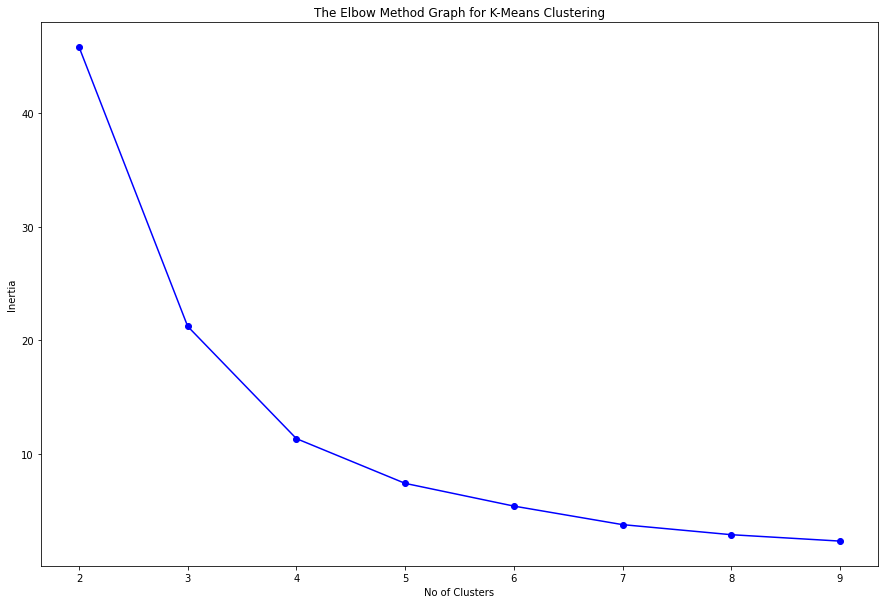

In [16]:
KMeans_plot(df_cluster)

**Observation:** Based on the elbow method graph above, we can conclude that 4 clusters is the best cluster since there is only slight difference in inertia after 4 clusters. It also coincides with our classified labels. Thus, we will proceed to cluster into 4 group 

In [18]:
kmeans_cluster = KMeans(n_clusters = 4, random_state=42)
kmeans_cluster.fit_predict(df_cluster)

array([2, 0, 1, ..., 1, 0, 1])

In [19]:
df['label'] = kmeans_cluster.labels_

Text(0.5, 1.0, 'Valence vs Energy Graph on Song Dataset')

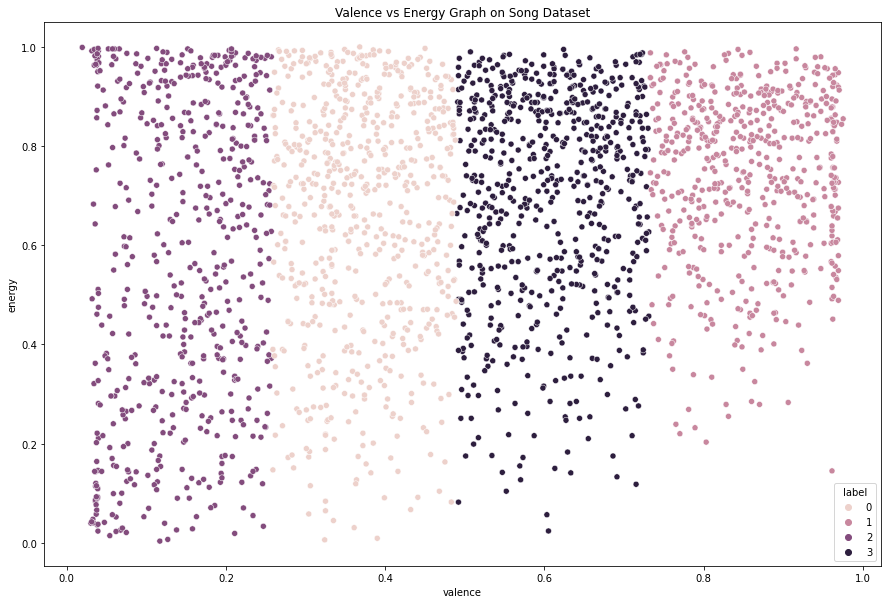

In [22]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='valence', y='energy', hue='label')
plt.title('Valence vs Energy Graph on Song Dataset')

In [21]:
df

,id,genre,track_name,artist_name,valence,energy,label
0,1dYGSsernyg8N0bMRgtO9Y,acoustic,I Was Only 19 (Live From 'The People Speak'),Julia Stone,0.231,0.135,2
1,7t8XsIXmzip7ZOdBm4OZtz,acoustic,Turn To You - (Mother's Day Dedication),Justin Bieber,0.279,0.720,0
2,2ds9vlk6o6BRCc2FAkmOvX,acoustic,Beat It,Fall Out Boy,0.841,0.936,1
3,6mTnbyE5dsvXksrL86EbJU,acoustic,Handens fem fingrar,Lisa Nilsson,0.468,0.104,0
4,5O7plifmVLzQK6PQaoPbTB,acoustic,Move Like You Want - Live In York/2011,Ben Howard,0.604,0.755,3
...,...,...,...,...,...,...,...
2428,3QOehiIQTEl4ecxFyYA7u8,world-music,Tríptico,Gotan Project,0.175,0.700,2
2429,0PHGV9pWYv91WCeCXhdWye,world-music,Triste,Elis Regina,0.448,0.322,0
2430,2UDFkcyY8nmk45kNj6ZSBr,world-music,Bassekou,Bassekou Kouyate,0.964,0.756,1
2431,3eTdGNpKtMkcX3e4wti4r7,world-music,Rekaxing Instrumental Music,Pet Music World,0.306,0.115,0


In [ ]:
df.to_csv('csv/valence_arousal_dataset.csv', index=False)

## Creating Recommend Criteria Dataset

For the recommendation, we would like to set a range of minimum and maximum value of energy and valence based on the classified acoustic scene. Therefore, we would try categorize the valence range based on the label that we have.

In [7]:
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2]
df_3 = df[df['label'] == 3]

In [24]:
def GetSample(df):
    sample = df.sample(n=5)
    sample_id = sample['id'].tolist()
    
    tracks = sp.tracks(sample_id)
    
    for track in tracks['tracks']:
        print('track    : ' + track['name'])
        
        if track['preview_url'] is not None:
            print('audio    : ' + track['preview_url'])
        else:
            print('audio    : Not Available' )
            
        print('cover art: ' + track['album']['images'][0]['url'])
        print()

In [25]:
GetSample(df_0) # metro

track    : Brown Skin
audio    : Not Available
cover art: https://i.scdn.co/image/ab67616d0000b273b59b0fd58024a97c9d51f43a

track    : シンシアの光
audio    : Not Available
cover art: https://i.scdn.co/image/ab67616d0000b273684e53ab8818a77a5d062fb0

track    : Breeding the Spawn
audio    : https://p.scdn.co/mp3-preview/6b4800886d9ff0c289da70cf17cac9e9d63b0e75?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b273197b2beafcaa07e89acaf3b1

track    : Asuf D Alwa
audio    : https://p.scdn.co/mp3-preview/1264aa0ec156acdbc81f27f6c9b39e30bc771295?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b2730a2b1b5ab77afab2032073e2

track    : Booyah (feat. We Are Loud & Sonny Wilson) - Radio Edit
audio    : Not Available
cover art: https://i.scdn.co/image/ab67616d0000b273a7e25db46f757268f8bfaf4c



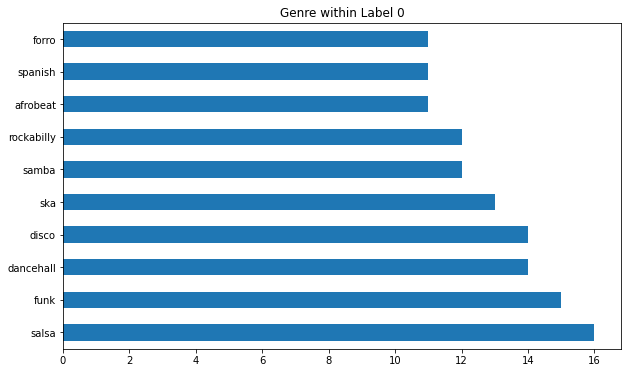

In [17]:
genre0 = df_0['genre'].value_counts()
plt.figure(figsize=(10,6))
genre0[:10].plot(kind='barh')
plt.title('Genre within Label 0')
plt.show()

For cluster 0, the songs that inside has a very high valence which in a sense feels like a very uptension music. This resonantes with the soundscape of metro where there is a lot of mechanical sound, air and people.

In [26]:
GetSample(df_1) # bus

track    : Sunday - Remastered
audio    : Not Available
cover art: https://i.scdn.co/image/ab67616d0000b27311698f9391d77f723747bedd

track    : Miami Maculelê
audio    : https://p.scdn.co/mp3-preview/1e9907c9b3b0a9bd5aa7986eac8e5a9c3f71b53a?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b273861e9a6657232785f11b9085

track    : Baby
audio    : https://p.scdn.co/mp3-preview/9290b1b995787cbea30eb6cb491fe812e6a34db0?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b2736276e51804a1160c6314e758

track    : DARE
audio    : https://p.scdn.co/mp3-preview/e4357997d5d86ec158ead950240bd175079f595e?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b27319d85a472f328a6ed9b704cf

track    : When I Come Around
audio    : https://p.scdn.co/mp3-preview/4453e5851f9aedbdd79c7ca010e908c179a32518?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b273db89b08034de626ebee68

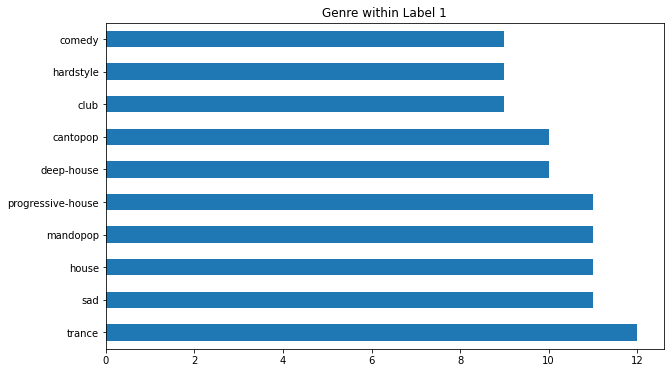

In [18]:
genre1 = df_1['genre'].value_counts()
plt.figure(figsize=(10,6))
genre1[:10].plot(kind='barh')
plt.title('Genre within Label 1')
plt.show()

For cluster 1, the songs inside has a layback feel to them and based on our perspective, it resonates well with a bus soundscape

In [27]:
GetSample(df_2) # park

track    : Recess
audio    : https://p.scdn.co/mp3-preview/626a714de17039f8e9d90e6748637a127b12fcca?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b273f034b00d0a05cd6504b49beb

track    : As Loke Falls
audio    : https://p.scdn.co/mp3-preview/30f07ee63ac50c6e0cc24d3a74691e9e378fbf85?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b2731549dcf0d4151486f71eae4d

track    : Afer Ventus
audio    : https://p.scdn.co/mp3-preview/e981a55d13f41192bd3caf09d7ff18558e8b9b1d?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b273508c86c93151fdbbeb8f033d

track    : Say Something
audio    : https://p.scdn.co/mp3-preview/24ca5de29a9f36302d19e85527fb68368cba7c3a?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b273554488d0c51967b1654d8ce5

track    : Tommy's Theme - Original Mix
audio    : Not Available
cover art: https://i.scdn.co/image/ab67616d0000b273b7772f02f

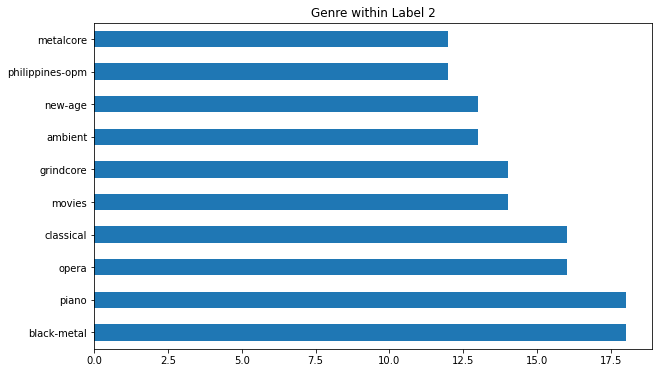

In [19]:
genre2 = df_2['genre'].value_counts()
plt.figure(figsize=(10,6))
genre2[:10].plot(kind='barh')
plt.title('Genre within Label 2')
plt.show()

For cluster 2, the songs have similar vibe to a park ambience, therefore we will label it for park

In [28]:
GetSample(df_3) # street_traffic

track    : Brand New Girlfriend
audio    : https://p.scdn.co/mp3-preview/a3598a4313348070c79f805ba56447015e2bfbfb?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b273823f57ce2073dbb2cbb0c9be

track    : サタンレイヴ
audio    : https://p.scdn.co/mp3-preview/4c8fbaf72996ed36818a0b92d20e85c1f4f70067?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b2734e4ad70eb7aea500abc13056

track    : The Donkey On Full House
audio    : Not Available
cover art: https://i.scdn.co/image/ab67616d0000b273a9e6f5bbc73e1e1d89c7dbeb

track    : Índios
audio    : https://p.scdn.co/mp3-preview/8c28e730e2b4d0168cccc7f1d5cc795745bd7076?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b2733035f33101cf3c84a83e2db7

track    : Passiona
audio    : https://p.scdn.co/mp3-preview/2f6517e664398cc8001b62798a333ed2ec85b52e?cid=6c685395299444f5bdeb492c9baced22
cover art: https://i.scdn.co/image/ab67616d0000b2739994648a01fa513b

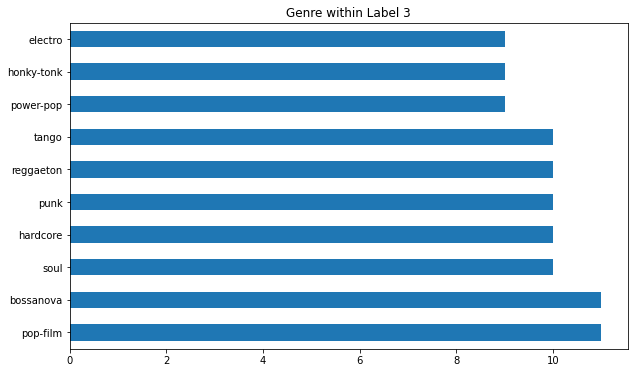

In [20]:
genre3 = df_3['genre'].value_counts()
plt.figure(figsize=(10,6))
genre3[:10].plot(kind='barh')
plt.title('Genre within Label 3')
plt.show()

For cluster 3, the songs has higher upbeat feel to them. Thus, it represents street_traffic quite well, since there are a lot of noises around the street that have similar vibe

In [29]:
label_dict = {0: 'metro',
              1: 'bus',
              2: 'park',
              3: 'street_traffic'
             }

We would also further cluster the energy range into 3 categories in order to differentiate the timing when the classification is done.

In [39]:
df_energy = df.groupby('label')['energy'].agg([min, max])
df_energy.reset_index(inplace=True)

df_energy['label'] = df_energy['label'].apply(lambda x: label_dict[x])
df_energy.sort_values(by='max', inplace=True, ascending=False)
df_energy.reset_index(drop= True, inplace=True)
df_energy

,label,min,max
0,metro,0.00591,1.000
1,park,0.00341,0.999
2,bus,0.14500,0.996
3,street_traffic,0.02380,0.995


In [40]:
part = (df_energy['max'] - df_energy['min']) / 3
df_energy['2nd'] = df_energy['min'] + part
df_energy['3rd'] = df_energy['max'] - part

df_energy = df_energy[['label','min','2nd','3rd','max']]
df_energy.rename(columns={'min':'energy_min', 
                         '2nd':'energy_2nd', 
                         '3rd':'energy_3rd', 
                         'max':'energy_max'}, inplace=True)

df_energy

,label,energy_min,energy_2nd,energy_3rd,energy_max
0,metro,0.00591,0.337273,0.668637,1.000
1,park,0.00341,0.335273,0.667137,0.999
2,bus,0.14500,0.428667,0.712333,0.996
3,street_traffic,0.02380,0.347533,0.671267,0.995


In [43]:
df_valence = df.groupby('label')['valence'].agg([min,max])
df_valence.reset_index(inplace=True)

df_valence['label'] = df_valence['label'].apply(lambda x: label_dict[x])
df_valence.rename(columns={'min':'valence_min', 
                           'max':'valence_max'}, inplace=True)
df_valence

,label,valence_min,valence_max
0,metro,0.2590,0.489
1,bus,0.7330,0.975
2,park,0.0196,0.257
3,street_traffic,0.4900,0.731


In [47]:
df_criteria = df_valence.merge(df_energy, on='label')
df_criteria

,label,valence_min,valence_max,energy_min,energy_2nd,energy_3rd,energy_max
0,metro,0.2590,0.489,0.00591,0.337273,0.668637,1.000
1,bus,0.7330,0.975,0.14500,0.428667,0.712333,0.996
2,park,0.0196,0.257,0.00341,0.335273,0.667137,0.999
3,street_traffic,0.4900,0.731,0.02380,0.347533,0.671267,0.995


In [136]:
df_criteria.to_csv('csv/recommend_criteria.csv', index=False)

## Application as Proof of Concept

In conclusion, we have prepared an application as proof of concept to test out the functionalibity of the recommender. To initate the app, we need to access the terminal and run the `app.py` script with streamlit package.  

The command to start the app is as follows:  
`streamlit run app.py`

## Conclusion

The model that we are using which is a **Long Short-Term Memory Neural Network** algorithm. Upon fitting the train dataset, we obtained the accuracy of prediction as follows:  
  

|Dataset|Accuracy|Loss|
|:---|:---:|:---|
|train|0.9542|0.137204|
|validation|0.8959|0.341624|
|test(unseen)|0.5711|1.9916|

The accuracy and loss is quite good for the train and validation dataset. However, for the test dataset, the model accuracy drops by substantial percentage (30%). This maybe due to the emergence of overfitting to the train dataset. Another aspect, that may contribute to these is the metrics value chosen.

It is an interesting findings since the audio files originate from the same file which has been splitted to a 1-second clips. This may happened due to the different audio profile of different clips within the same file.

### Limitations

- The acoustic scene that we are trying to classify only consists of 4 scenes. It does not cover other acoustic scene that also utilise music on the scene, such as cafe, restaurant, lobby, club, gym, etc
- Limitation of time to explore more on the model tuning or even other type of deep learning model that may have better prediction for the dataset.
- Limited dataset on the valence and energy relation to acoustic scene. Most of the dataset only has the feature values for songs.
- The microphone and machine could not detect the ambience sound that is needed to be classified from the app. Load audio features only is functional at the time being.

### Future Works

- Improve the model accuracy by tuning the current the model or introduce different type of deep learning model. We may choose different metrics to be selected as well.
- Increase the number of acoustic scene that can be classified to have a more better classification model that fits every acoustic scene.
- Collect data that represent the valence and energy value based on the acoustic scene to achieve a better representation of the value range that is inputted to the Spotify recommender.
- Develop an Android software to deploy the app in order for us to use the recording features, since the phone microphone can capture a better audio. 